# Evaluate Effect of Starting Model
Compare a model which started from our original TTM weights, and another which was trained using 25000 more TTM entries.
We'd like to know if training using additional TTM entries reduces the need for DFT data to acheive a target accuracy.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
import pandas as pd
import utils
import json

## Load in Examples
We only vary the sampling method, keeping the number of structures produced and the target error constant.
We selected a target error of 2.5 meV/atom because it gave us a model that performed well against a hold-out set and produced better structure when used for MCTBP.

In [2]:
runs = list(Path('../prod-runs/').glob('dft_md*'))
print(f'Found {len(runs)} runs')

Found 4 runs


Make sure training parameters for the network were the same

In [3]:
params = json.loads((runs[0] / 'final-model' / 'params.json').read_text())
params.pop('run_dir')
for run in runs:
    duplicates = json.loads((run / 'duplicates.json').read_text())
    for dup in duplicates:
        dup = Path(dup)
        my_params = json.loads((dup / 'final-model' / 'params.json').read_text())
        my_params.pop('run_dir')
        assert my_params == params, f'{dup} is different than {runs[0]}. {params} != {my_params}'

## Compare Against Hold-out Set
Using the same procedure as last notebook

In [4]:
data = utils.assess_against_holdout(runs, ['starting_model', 'num_to_run'])
data['model_name'] = data['starting_model'].apply(lambda x: 'Refined' if 'dft_' in x else 'Initial')

We now have the errors and for each error tolerance

In [5]:
data

,name,starting_model,num_to_run,n_duplicates,energy_error_per_atom-mean,energy_error_per_atom-sem,force_rmsd-mean,force_rmsd-sem,energy_error_per_atom-init-mean,energy_error_per_atom-init-sem,force_rmsd-init-mean,force_rmsd-init-sem,model_name
0,dft_md-1000_ttm-25000,../../notebooks/initial-models/dft_post-ttm-re...,1000,1,2.563923,0.332872,0.269799,0.019148,3.768799,0.672013,0.492776,0.02801,Refined
1,dft_md-10000_starting-model,../../notebooks/initial-models/dft/starting-model,10000,1,1.669165,0.237735,0.219360,0.019284,3.772808,0.671670,0.492776,0.02801,Initial
2,dft_md-10000_ttm-25000,../../notebooks/initial-models/dft_post-ttm-re...,10000,1,1.661782,0.225142,0.220743,0.017895,3.770166,0.671870,0.492776,0.02801,Refined
3,dft_md-1000_starting-model,../../notebooks/initial-models/dft/starting-model,1000,1,1.838901,0.193102,0.300694,0.016785,3.769067,0.671940,0.492776,0.02801,Initial


Make a figure

Text(0.5, 0, 'Run Length')

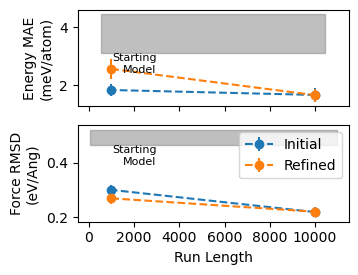

In [6]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(3.5, 2.75))

for ax, t in zip(axs, ['energy_error_per_atom', 'force_rmsd']):
    for name, group in data.groupby('model_name'):
        # Plot the tuned model
        ax.errorbar(group['num_to_run'], group[f'{t}-mean'],
                    fmt='--o', yerr=group[f'{t}-sem'], label=name)

    # Plot the initial model
    row = data.iloc[0]
    ax.fill_between(ax.get_xlim(),
                    y1=row[f'{t}-init-mean'] + row[f'{t}-init-sem'],
                    y2=row[f'{t}-init-mean'] - row[f'{t}-init-sem'],
                   color='gray', alpha=0.5)
    ax.text(3000, row[f'{t}-init-mean'] - row[f'{t}-init-sem'], 'Starting\nModel',
           ha='right', va='top', fontsize=8)
    
ax.legend()
    
axs[0].set_ylabel('Energy MAE\n(meV/atom)')
axs[1].set_ylabel('Force RMSD\n(eV/Ang)')
axs[-1].set_xlabel('Run Length')

The initial model does better on this test, but I would like to revisit the test set which I use. It might be biased towards high-energy structures.

## Repeat with MCTBP
See if the sampling methods improve performance

In [7]:
data = utils.assess_from_mctbp_runs(runs, ['starting_model', 'num_to_run'])
data['model_name'] = data['starting_model'].apply(lambda x: 'Refined' if 'dft_' in x else 'Initial')

Summarize all runs

In [8]:
data.sort_values('num_to_run')

,name,starting_model,num_to_run,n_duplicates,number_sampled,energy_error-mean,energy_error-sem,force_error-mean,force_error-sem,max_force-mean,max_force-sem,tau-mean,tau-sem,model_name
0,dft_md-1000_ttm-25000,../../notebooks/initial-models/dft_post-ttm-re...,1000,1,304,10.659224,0.778148,2.829169,0.099235,1.104597,0.065210,0.693783,0.031973,Refined
3,dft_md-1000_starting-model,../../notebooks/initial-models/dft/starting-model,1000,1,228,10.549111,1.076842,2.858850,0.122586,1.190271,0.083366,0.634528,0.066162,Initial
1,dft_md-10000_starting-model,../../notebooks/initial-models/dft/starting-model,10000,1,304,8.279186,0.493348,2.559878,0.096280,1.117348,0.072335,0.684551,0.061894,Initial
2,dft_md-10000_ttm-25000,../../notebooks/initial-models/dft_post-ttm-re...,10000,1,303,8.053298,0.522050,2.552005,0.115956,1.274722,0.086691,0.757997,0.039868,Refined


Plot the errors

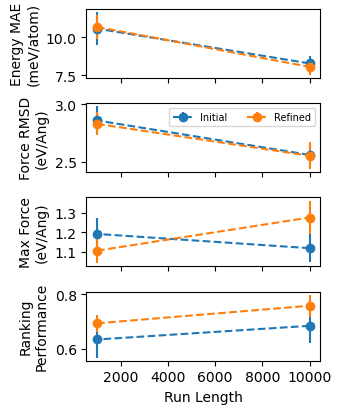

In [12]:
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(3.5, 4.25))

for ax, t in zip(axs, ['energy_error', 'force_error', 'max_force', 'tau']):
    for label, group in data.groupby('model_name'):
        # Plot the tuned model
        ax.errorbar(group['num_to_run'], group[f'{t}-mean'], fmt='--o', yerr=group[f'{t}-sem'], label=label)
    
   
axs[0].set_ylabel('Energy MAE\n(meV/atom)')
axs[1].set_ylabel('Force RMSD\n(eV/Ang)')
axs[2].set_ylabel('Max Force\n(eV/Ang)')
axs[3].set_ylabel('Ranking\nPerformance')
axs[-1].set_xlabel('Run Length')
axs[1].legend(ncol=2, fontsize=7)

fig.tight_layout()

It seems like the refined model performs slightly better on all aspects except the "maximum force" (a measure of how well relaxed the produced structures are). The changes are only notable for the ranking performance, which happen to be the one I care most about as I want to know that the structures we identify as global minima are indeed global minima. The actual energy matters less.

We should re-run these tests with even more numbers of MCTBP steps to reduce the error bars further.